In [1]:
import sys
sys.path.append("../library")

In [2]:
from __future__ import print_function, division
import scipy
import pandas as pd
import math
import numpy as np
from thinkbayes2 import Suite, Joint, Pmf
import matplotlib.pyplot as plt
import thinkplot

In [3]:
def StrafingSpeed(alpha, beta, x):
    """
    P((beta, alpha)) * speed = 1, then we can estimate P((beta, alpha)).
    """
    theta = math.atan2(x - alpha, beta)
#     print(theta)
    speed = beta / math.cos(theta) ** 2
    return speed

In [4]:
def MakeLocationPmf(alpha, beta, locations):
    """
    generate pmf for (beta, alpha)
    """
    pmf = Pmf()
    for x in locations:
#         print(alpha, beta, x)
        # need to guarantee beta != 0 
        prob = 1.0 / StrafingSpeed(alpha, beta, x)
        pmf.Set(x, prob)
    pmf.Normalize()
    return pmf

In [5]:
class Paintball(Suite, Joint):
    """
    Paint ball for estimation of probablity of shooter position (alpha, beta)
    """
    def __init__(self, alphas, betas, locations):
        """
        based on possible tuple (alpha, beta, location) to estimate probablity.
        """
        self.locations = locations
        pairs = [(alpha, beta) for alpha in alphas for beta in betas]
        super().__init__(pairs)
        
    def Likelihood(self, data, hypo):
        """
        calculate likelihood based on data and hypo.
        """
        alpha, beta = hypo
        x = data
        pmf = MakeLocationPmf(alpha, beta, self.locations)
        like = pmf.Prob(x)
        return like

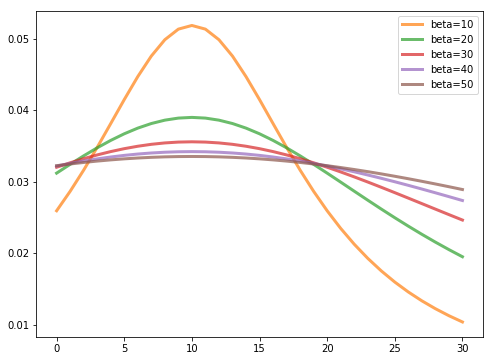

In [6]:
# set alpha = 10, we check betas=range(1, 51) pmf probability
alpha = 10
betas = range(1, 51)
locations = range(31)
COLOR_NUM = 10

# thinkplot for visualization, only for case 10 * n
thinkplot.Clf()
thinkplot.PrePlot(num=2)

for beta in betas:
    pmf = MakeLocationPmf(alpha, beta, locations)
    # for color, refer to https://stackoverflow.com/questions/991027/how-to-calculate-a-mod-b-in-python
    if beta % COLOR_NUM == 0:
        # only draw beta = 10 * n, n is integer number
        thinkplot.Plot(pmf, label='beta={}'.format(beta), color='C{}'.format((beta+1) // COLOR_NUM))

plt.legend()
plt.show()

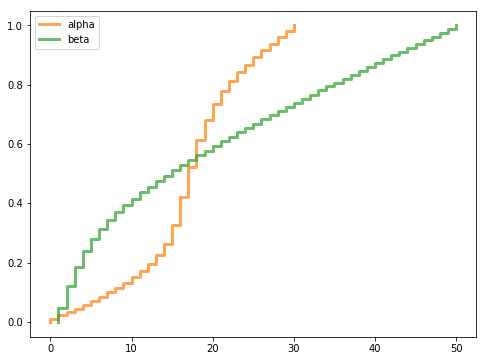

alpha CI : (14, 21)
beta CI : (5, 31)


In [7]:
# generate posterior distribution of alpha and beta
alphas = range(31)
betas = range(1, 51)
locations = range(31)
suite = Paintball(alphas, betas, locations)
suite.UpdateSet([15, 16, 18, 21])
# extract marginal distribution of alpha, beta from (alpha, beta) joint distribution
marginal_alpha = suite.Marginal(0)
marginal_beta = suite.Marginal(1)

# thinkplot for visualization for marginal CDF
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Cdf(marginal_alpha.MakeCdf(label='alpha'), color='C1')
thinkplot.Cdf(marginal_beta.MakeCdf(label='beta'), color='C2')
plt.legend()
plt.show()

# analysis of credibleInterval
print('alpha CI :', marginal_alpha.CredibleInterval(50))
print('beta CI :', marginal_beta.CredibleInterval(50))

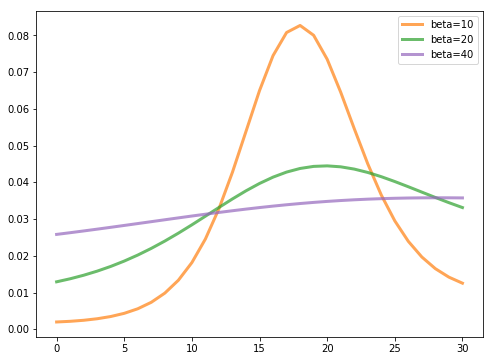

In [8]:
betas = [10, 20, 40]
COLOR_NUM = 10

# thinkplot for visualization, only for case 10 * n
thinkplot.Clf()
thinkplot.PrePlot(num=len(betas))

for beta in betas:
    cond = suite.Conditional(0, 1, beta)
    cond.name = 'beta = %d' % beta
    # approach 1: Using Pdf plot
    thinkplot.Pdf(cond, label='beta={}'.format(beta), color='C{}'.format((beta+1) // COLOR_NUM))
    # approach 2: Only draw beta = 10 * n, n is integer number
#     thinkplot.Plot(cond, label='beta={}'.format(beta), color='C{}'.format((beta+1) // COLOR_NUM))

plt.legend()
plt.show()
# We clearly see alpha & beta depend with each other. If they're independent, alpha|cond will be the same

In [9]:
def MakeCrediblePlot(suite):
    """
    credible plot for analysis of suite.
    """
    d = dict((pair, 0) for pair in suite.Values())
    percentages = [75, 50, 25]
    for p in percentages:
        interval = suite.MaxLikeInterval(p)
        for pair in interval:
            d[pair] += 1
    return d

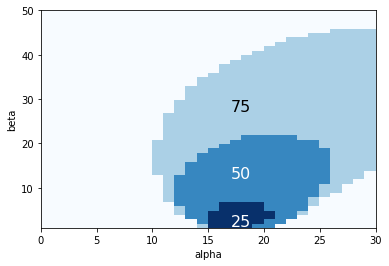

In [10]:
# refer to https://github.com/AllenDowney/ThinkBayes2/blob/master/code/paintball.py
d = MakeCrediblePlot(suite)
# visualization for contour
thinkplot.Contour(d, contour=False, pcolor=True)
thinkplot.Text(17, 4, '25', color='white')
thinkplot.Text(17, 15, '50', color='white')
thinkplot.Text(17, 30, '75')
plt.xlabel('alpha')
plt.ylabel('beta')
plt.show()